In [1]:
import matplotlib.pyplot as plt
import numpy as np

import ezephys.stimtools as st

# Types of stimuli

- `SimpleStimulus`
- `ConvolvedStimulus`
- `CompoundStimulus`

# `SimpleStimulus`

In [2]:
duration = 1e3  # 10s

sinewave = st.SinStimulus(mean=0, amplitude=5, frequency=3, duration=duration)
chirp = st.ChirpStimulus(mean=0, amplitude=10, initial_frequency=1, final_frequency=20, duration=duration)
synpulse = st.SynapticStimulus(amplitude=8, tau_rise=2, tau_decay=120, start_time=duration/2, duration=duration)
noise = st.OUStimulus(mean=0, amplitude=1, tau=5, ampli_modulation=0.5, mod_period=200, seed=42, duration=duration)

## Inspecting stimuli

Stimtools provides two ways to inspect stimulus objects after they are created: textually as a recipe, and visually as a plot.

In [3]:
sinewave

ez.stimtools.SinStimulus(mean=0, amplitude=5, frequency=3, label=None)

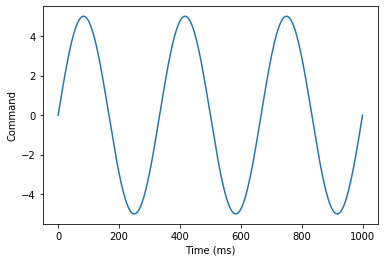

In [4]:
sinewave.plot()

## Customizing stimulus plots

Plots integrate seamlessly with matplotlib, allowing them to be customized using familiar syntax. (See `matplotlib.pyplot.plot` documentation for valid formatting parameters.)

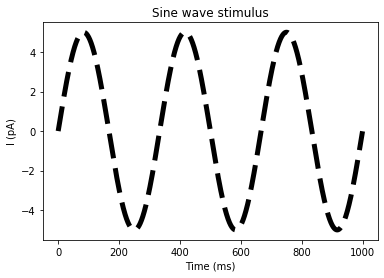

In [5]:
sinewave.plot(color='k', linewidth=5, linestyle='--', dashes=(5, 2))
plt.ylabel('I (pA)')
plt.title('Sine wave stimulus')

plt.show()

Plots can be inserted into specific panels of a matplotlib figure using the optional `ax` argument.

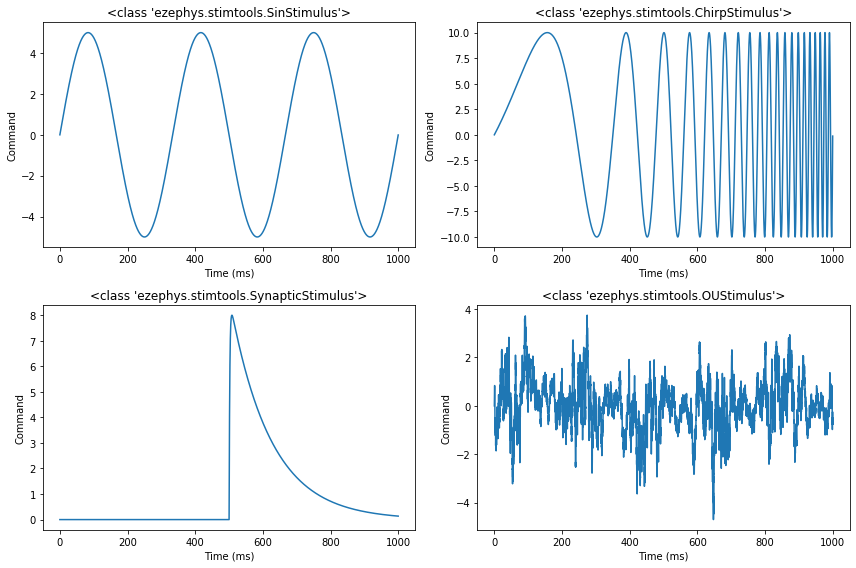

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten().tolist()

for ax, stim in zip(axes, [sinewave, chirp, synpulse, noise]):
    ax.set_title(type(stim))
    stim.plot(ax=ax)  # Send plot to a specific matplotlib.axes object.

plt.tight_layout()
plt.show()

# Synaptic trains: `ConvolvedStimulus`

Synaptic trains can be modelled as a stereotyped kernel (or waveform) convolved with a set of trigger events. `stimtools` supports convolved stimuli, including synaptic trains, via its `ConvolvedStimulus` class.

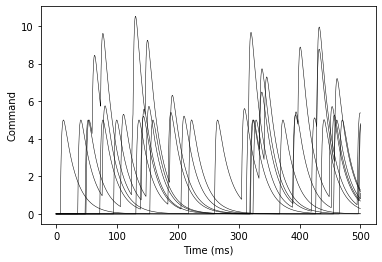

In [7]:
no_sweeps = 10
syntrain = st.ConvolvedStimulus(
    0, st.BiexponentialSynapticKernel(5, 2, 20), np.random.uniform(size=(no_sweeps, 5000)) < 0.001
)
syntrain.plot(color='k', lw=0.5)

# Assembling complicated stimuli: `CompoundStimulus`

Stimuli can be added together, yielding a `CompoundStimulus`.

In [8]:
compound = synpulse + noise
compound

In [9]:
print(compound)

ez.stimtools.SynapticStimulus(amplitude=8, tau_rise=2, tau_decay=120, label=None)
+ ez.stimtools.OUStimulus(mean=0, amplitude=1, tau=5, ampli_modulation=0.5, mod_period=200, seed=42, label=None)


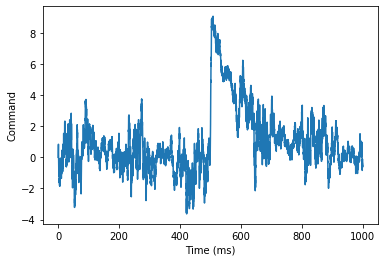

In [10]:
compound.plot()

`Stimulus` and array-like objects can be added together and concatenated to construct arbitrary stimuli.

concatenate(
	array_like,
	ez.stimtools.SynapticStimulus(amplitude=8, tau_rise=2, tau_decay=120, label=None)
+ ez.stimtools.OUStimulus(mean=0, amplitude=1, tau=5, ampli_modulation=0.5, mod_period=200, seed=42, label=None)
+ array_like,
	array_like
)


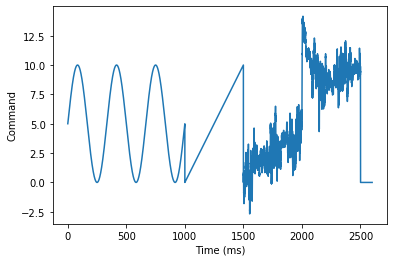

In [11]:
concat_compound = st.concatenate([
    sinewave + 5,
    np.linspace(0, 10, 5000),
    compound + np.linspace(0, 10, compound.no_timesteps), 
    [0 for i in range(1000)]
])

print(concat_compound)
concat_compound.plot()